<a href="https://colab.research.google.com/github/FatmaBuseBorlu/YuzGoruntulerindenDuyguTanimaveTepkiVerme/blob/main/RafDb-MobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from google.colab import files
import zipfile

In [2]:
# Yerel bilgisayardan ZIP dosyasını yükleme
uploaded = files.upload()

# ZIP dosyasını çıkarma
for file_name in uploaded.keys():
    if file_name.endswith(".zip"):
        with zipfile.ZipFile(file_name, 'r') as zip_ref:
            zip_ref.extractall("/content/DATASET")  # Veriyi /content/DATASET klasörüne çıkarır
        print(f"{file_name} başarıyla çıkarıldı.")

# Klasörleri Bulma Fonksiyonu
def find_class(directory_path):
    if not os.path.exists(directory_path):
        raise ValueError(f"The directory '{directory_path}' does not exist.")
    if not os.path.isdir(directory_path):
        raise ValueError(f"The path '{directory_path}' is not a directory.")

    all_entries = os.listdir(directory_path)
    folders = [entry for entry in all_entries if os.path.isdir(os.path.join(directory_path, entry))]
    return folders

Saving raf-db-dataset.zip to raf-db-dataset.zip
raf-db-dataset.zip başarıyla çıkarıldı.


In [6]:
# Veri Yükleme ve Ön İşleme
DIRECTORY = "/content/DATASET/RAF-DB-DATASET/DATASET"
train_dir = "/content/DATASET/DATASET/train"
test_dir = "/content/DATASET/DATASET/test"

In [7]:
# Veri artırma
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='sparse')
test_data = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=32, class_mode='sparse')

Found 12271 images belonging to 7 classes.
Found 3068 images belonging to 7 classes.


In [11]:
# MobilenetV2 Modelini Kurma
mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Model Yapısı
model = Sequential([
    mobilenet,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(7, activation='softmax')
])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
# Modeli Derleme
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [13]:
# Callback'ler
checkpoint = ModelCheckpoint('mobilenetv2_emotion_recognition.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1) # Changed the filepath to end with .keras
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

callbacks = [checkpoint, early_stopping, reduce_lr]

In [14]:
# Modeli Eğitme
history = model.fit(train_data, validation_data=test_data, epochs=20, callbacks=callbacks)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.5340 - loss: 1.3123

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.45046, saving model to mobilenetv2_emotion_recognition.keras
384/384 ━━━━━━━━━━━━━━━━━━━━ 228s 465ms/step - accuracy: 0.5342 - loss: 1.3118 - val_accuracy: 0.4505 - val_loss: 3.1375 - learning_rate: 0.0010
Epoch 2/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.7004 - loss: 0.8493
Epoch 2: val_accuracy did not improve from 0.45046
384/384 ━━━━━━━━━━━━━━━━━━━━ 151s 393ms/step - accuracy: 0.7004 - loss: 0.8492 - val_accuracy: 0.2767 - val_loss: 4.8895 - learning_rate: 0.0010
Epoch 3/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.7389 - loss: 0.7537
Epoch 3: val_accuracy did not improve from 0.45046
384/384 ━━━━━━━━━━━━━━━━━━━━ 149s 389ms/step - accuracy: 0.7389 - loss: 0.7537 - val_accuracy: 0.3947 - val_loss: 9.1984 - learning_rate: 0.0010
Epoch 4/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.7614 - loss: 0.6855
Epoch 4: val_accuracy improved from 0.45046 to 0.49609, saving model to mobilenetv2_emotion

In [15]:
# Model Özeti
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,790,935 (29.72 MB)

 Trainable params: 2,585,607 (9.86 MB)

 Non-trainable params: 34,112 (133.25 KB)

 Optimizer params: 5,171,216 (19.73 MB)

96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.8364 - loss: 0.5937
Test Doğruluğu: 83.18%
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step
Confusion Matrix:
 [[ 38   3  13 133  46  26  70]
 [  9   1   6  30  11   3  14]
 [ 13   0  11  62  24  22  28]
 [127  19  60 474 209  82 214]
 [ 50   4  17 186  84  37 100]
 [ 20   1   8  65  30   6  32]
 [ 73  12  41 263 113  41 137]]
Classification Report:
               precision    recall  f1-score   support

    Surprise       0.12      0.12      0.12       329
        Fear       0.03      0.01      0.02        74
     Disgust       0.07      0.07      0.07       160
       Happy       0.39      0.40      0.40      1185
         Sad       0.16      0.18      0.17       478
       Anger       0.03      0.04      0.03       162
     Neutral       0.23      0.20      0.21       680

    accuracy                           0.24      3068
   macro avg       0.15      0.14      0.14      3068
weighted avg       0.25      0.24      0.24      3068



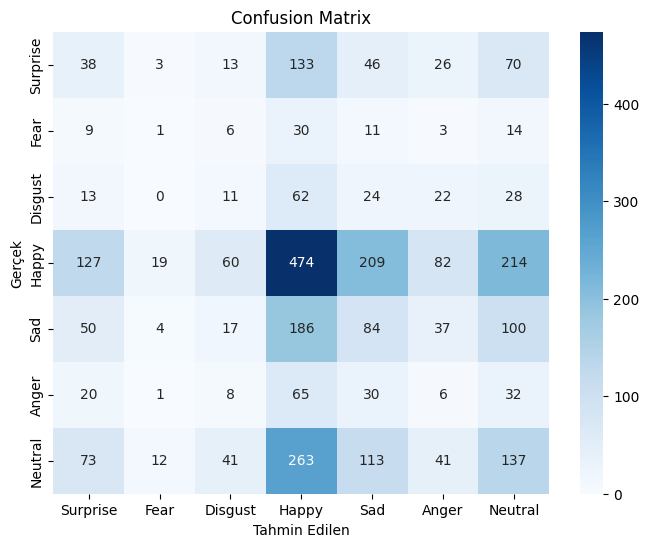

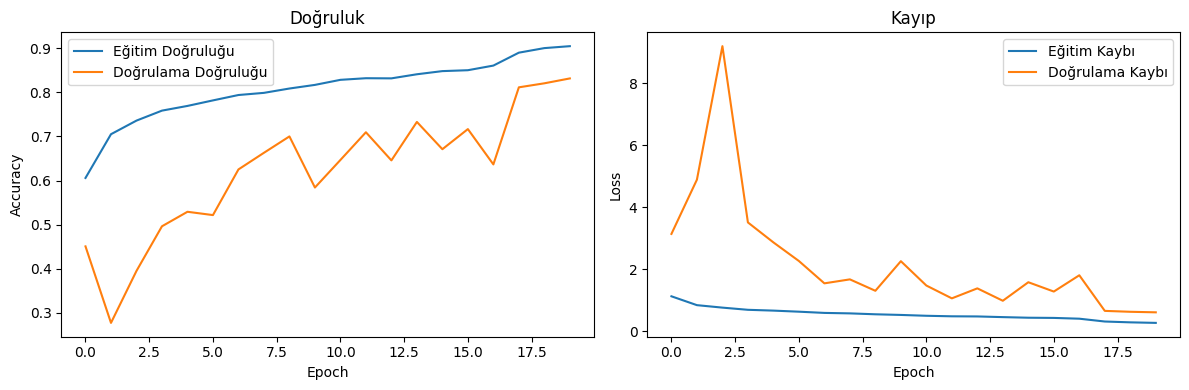

In [16]:
# MODELİ TEST ETME
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Doğruluğu: {test_accuracy * 100:.2f}%")

# TAHMİNLER
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_data.classes  # Gerçek etiketler

# SINIF ETİKETLERİ
emotion_labels = {0: "Surprise", 1: "Fear", 2: "Disgust", 3: "Happy", 4: "Sad", 5: "Anger", 6: "Neutral"}
CATEGORIES = list(emotion_labels.values())

# HATA MATRİSİ VE RAPOR
cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=CATEGORIES))

# CONFUSION MATRIX GÖRSELİ
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.title('Confusion Matrix')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.show()

# ÖĞRENME EĞRİLERİ
def plot_learning_curves(history):
    plt.figure(figsize=(12, 4))

    # Doğruluk Grafiği
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
    plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
    plt.title("Doğruluk")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Kayıp Grafiği
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Eğitim Kaybı')
    plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
    plt.title("Kayıp")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_learning_curves(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


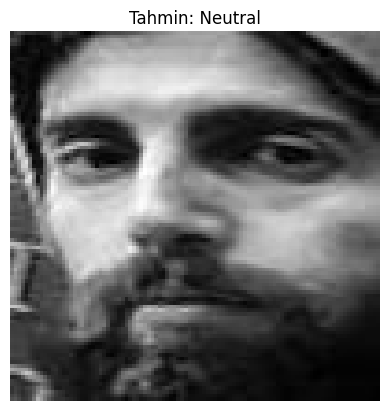

Modelin tahmini: Neutral
Gerçek sınıf (klasör ismi): 7


In [17]:
# RASTGELE BİR GÖRÜNTÜDEN TAHMİN
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Rastgele bir görüntü seç (test klasöründen)
class_names = os.listdir(test_dir)
selected_class = random.choice(class_names)
selected_image = random.choice(os.listdir(os.path.join(test_dir, selected_class)))
image_path = os.path.join(test_dir, selected_class, selected_image)

# Görüntüyü yükle ve işle
img = load_img(image_path, target_size=(224, 224))
img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Tahmin yap
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)
predicted_label = emotion_labels[predicted_class]

# Görüntüyü göster
plt.imshow(load_img(image_path))
plt.title(f"Tahmin: {predicted_label}")
plt.axis("off")
plt.show()

print(f"Modelin tahmini: {predicted_label}")
print(f"Gerçek sınıf (klasör ismi): {selected_class}")